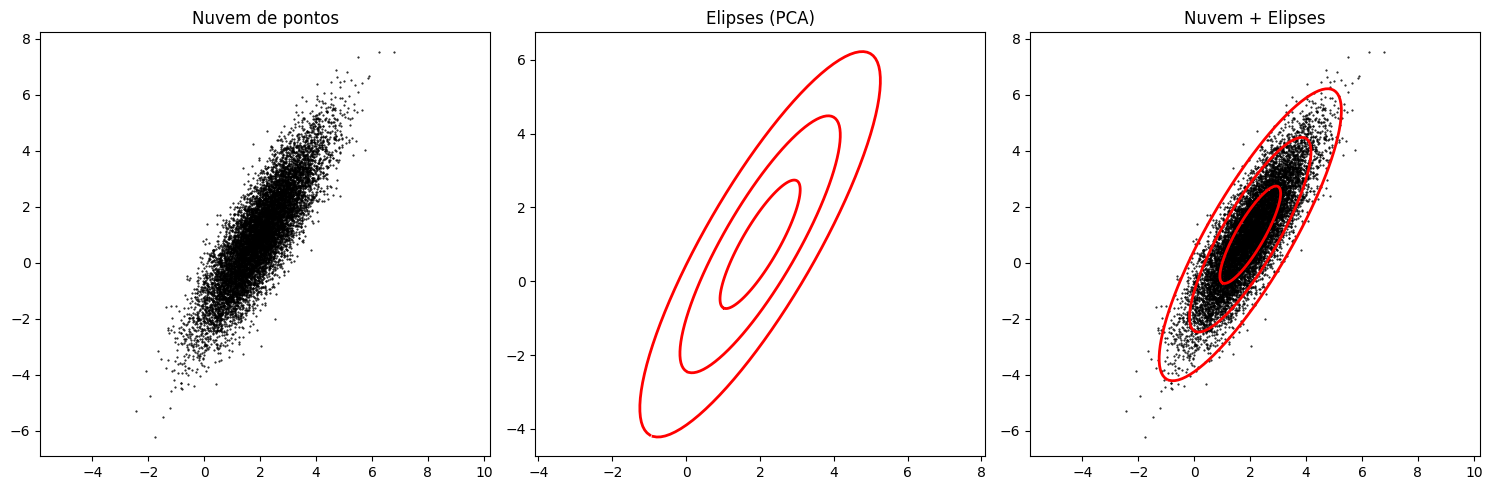

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Criar figura com 3 eixos lado a lado
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Dados da nuvem
xC = np.array([2, 1])  # Centro
sig = np.array([2, 0.5])  # Eixos principais
theta = np.pi / 3       # Rotação
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
nPoints = 10000
X = R @ np.diag(sig) @ np.random.randn(2, nPoints) + np.diag(xC) @ np.ones((2, nPoints))

# Plot nuvem de pontos no ax1
ax1.plot(X[0, :], X[1, :], '.', color='k', markersize=1)
ax1.set_title("Nuvem de pontos")
ax1.axis('equal')

# Média e SVD
Xavg = np.mean(X, axis=1)
B = X - np.tile(Xavg, (nPoints, 1)).T
U, S, VT = np.linalg.svd(B / np.sqrt(nPoints), full_matrices=False)

# Pontos para as elipses
theta = 2 * np.pi * np.arange(0, 1, 0.01)
Xstd = U @ np.diag(S) @ np.array([np.cos(theta), np.sin(theta)])

# Plot só das elipses no ax2
for scale in [1, 2, 3]:
    ax2.plot(Xavg[0] + scale * Xstd[0, :], Xavg[1] + scale * Xstd[1, :],
             '-', color='r', linewidth=2)
ax2.set_title("Elipses (PCA)")
ax2.axis('equal')

# Plot nuvem + elipses no ax3
ax3.plot(X[0, :], X[1, :], '.', color='k', markersize=1)
for scale in [1, 2, 3]:
    ax3.plot(Xavg[0] + scale * Xstd[0, :], Xavg[1] + scale * Xstd[1, :],
             '-', color='r', linewidth=2)
ax3.set_title("Nuvem + Elipses")
ax3.axis('equal')

plt.tight_layout()
plt.show()


[INFO] X shape: (216, 4000) (N amostras, D features).
[INFO] labels: (array(['Cancer', 'Normal'], dtype=object), array([121,  95]))


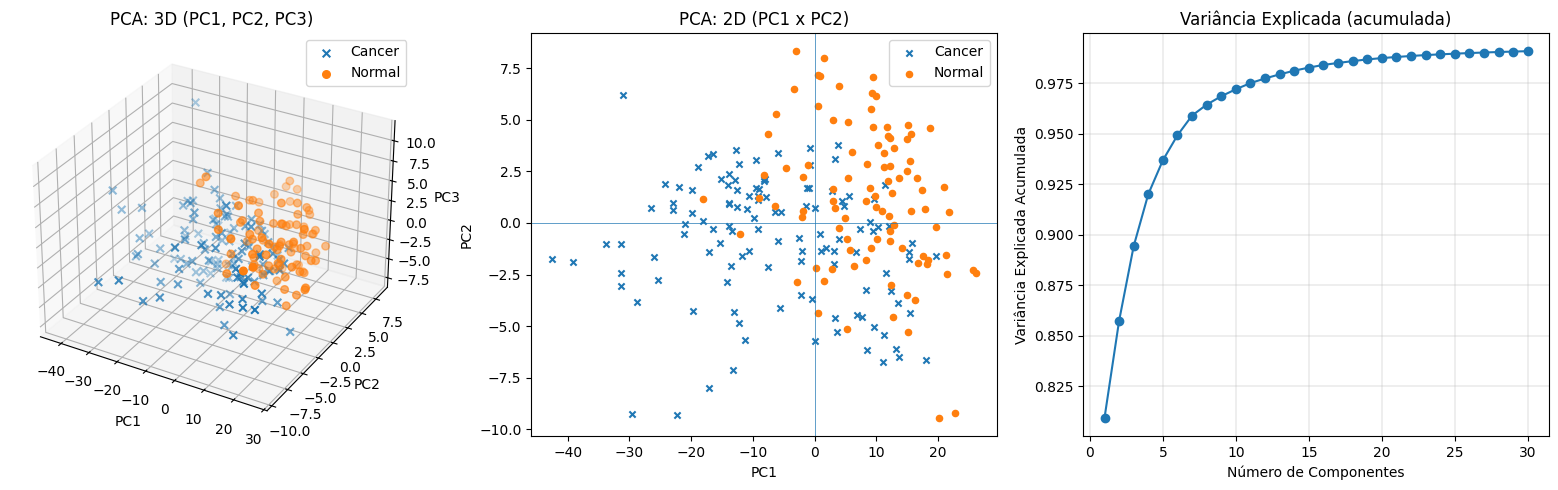

[INFO] 10 primeiras razões de variância explicada:
[0.8094 0.048  0.037  0.0257 0.0168 0.0124 0.0098 0.0054 0.0042 0.0034]
[INFO] Variância acumulada (10 PCs): 0.972


In [5]:
# -*- coding: utf-8 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================================
# CONFIG
# =========================================
OBS_CSV = 'ovariancancer_obs.csv'   # expressão gênica (216 x 4000)
GRP_CSV = 'ovariancancer_grp.csv'   # rótulos (Cancer/Normal ou 1/0)
OBS_NPY = 'ovariancancer_obs.npy'
GRP_NPY = 'ovariancancer_grp.npy'
CSV_HAS_HEADER = False              # mude para True se seus CSVs tiverem cabeçalho
CSV_SEP = ','                       # mude para ';' se necessário

# =========================================
# FUNÇÕES AUXILIARES
# =========================================
def load_or_build_arrays():
    """
    Carrega .npy, ou lê .csv e salva .npy. Retorna (X, labels).
    labels será um array de strings: 'Cancer' ou 'Normal'.
    """
    # 1) Tenta carregar .npy
    if os.path.exists(OBS_NPY) and os.path.exists(GRP_NPY):
        X = np.load(OBS_NPY)
        labels = np.load(GRP_NPY)
        # Garante tipo str
        labels = labels.astype(str)
        return X, labels

    # 2) Lê CSVs
    header = 0 if CSV_HAS_HEADER else None
    # Observações: matriz (N x D)
    obs_df = pd.read_csv(OBS_CSV, header=header, sep=CSV_SEP)
    # Alguns dumps vêm com linhas/cols vazias no fim; remove colunas totalmente vazias
    obs_df = obs_df.dropna(axis=1, how='all')
    # Preenche eventuais NaNs com 0 (ou outra estratégia desejada)
    obs_df = obs_df.fillna(0.0)
    X = obs_df.values

    # Rótulos: coluna única
    grp_df = pd.read_csv(GRP_CSV, header=header, sep=CSV_SEP)
    # Se houver múltiplas colunas por acidente, pega a primeira não vazia
    if grp_df.shape[1] > 1:
        # Tenta detectar coluna com conteúdo não-nulo
        col = grp_df.apply(lambda c: c.notna().sum()).idxmax()
        grp_series = grp_df[col]
    else:
        grp_series = grp_df.iloc[:, 0]

    # Normaliza espaços e tipo
    grp_series = grp_series.astype(str).str.strip()

    # Mapeia 0/1 para texto, se aplicável
    lower = grp_series.str.lower()
    # tenta detectar se são números codificados em string
    if set(lower.unique()) <= set(['0', '1', '0.0', '1.0']):
        mapped = grp_series.replace({'1': 'Cancer', '0': 'Normal',
                                     '1.0': 'Cancer', '0.0': 'Normal'})
        labels = mapped.values
    else:
        # Padroniza capitalização
        labels = np.where(lower.values == 'cancer', 'Cancer',
                 np.where(lower.values == 'normal', 'Normal', grp_series.values))

    # Salva como .npy
    np.save(OBS_NPY, X)
    np.save(GRP_NPY, labels)

    return X, labels

def pca_via_svd(X):
    """
    PCA usando SVD direto em dados centrados.
    Retorna: proj (N x D), VT (D x D), S (min(N,D)), Xmean (D,)
    """
    # Centraliza
    Xmean = X.mean(axis=0)
    Xc = X - Xmean
    # SVD em Xc (N x D)
    U, S, VT = np.linalg.svd(Xc, full_matrices=False)
    # Projeção nos componentes (scores) = U * S
    proj = U * S  # shape (N x D)
    return proj, VT, S, Xmean

def explained_variance_ratio(S, n_samples):
    """
    Converte singular values S em variância explicada (PCA) e retorna
    variância explicada por componente e acumulada.
    """
    # Em PCA, eigenvalues dos PCs = (S^2) / (n_samples - 1)
    eigvals = (S ** 2) / (n_samples - 1)
    total = eigvals.sum()
    ratio = eigvals / total
    cum = np.cumsum(ratio)
    return ratio, cum

# =========================================
# MAIN
# =========================================
if __name__ == '__main__':
    # Carrega dados
    X, labels = load_or_build_arrays()
    N, D = X.shape
    print(f'[INFO] X shape: {X.shape} (N amostras, D features).')
    print(f'[INFO] labels: {np.unique(labels, return_counts=True)}')

    # PCA via SVD
    proj, VT, S, Xmean = pca_via_svd(X)
    ratio, cum = explained_variance_ratio(S, N)

    # Seleciona PCs
    pc1, pc2, pc3 = 0, 1, 2
    scores3D = proj[:, [pc1, pc2, pc3]]  # N x 3

    # Separação por grupo
    is_cancer = (labels == 'Cancer')
    is_normal = (labels == 'Normal')

    # =========================================
    # PLOTS
    # =========================================
    fig = plt.figure(figsize=(16, 5))

    # (A) 3D PC1–PC2–PC3
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(scores3D[is_cancer, 0], scores3D[is_cancer, 1], scores3D[is_cancer, 2],
                marker='x', s=30, label='Cancer')
    ax1.scatter(scores3D[is_normal, 0], scores3D[is_normal, 1], scores3D[is_normal, 2],
                marker='o', s=30, label='Normal')
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax1.set_title('PCA: 3D (PC1, PC2, PC3)')
    ax1.legend(loc='best')

    # (B) 2D PC1–PC2
    ax2 = fig.add_subplot(132)
    ax2.scatter(proj[is_cancer, pc1], proj[is_cancer, pc2], marker='x', s=20, label='Cancer')
    ax2.scatter(proj[is_normal, pc1], proj[is_normal, pc2], marker='o', s=20, label='Normal')
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_title('PCA: 2D (PC1 x PC2)')
    ax2.legend(loc='best')
    ax2.axhline(0, linewidth=0.5)
    ax2.axvline(0, linewidth=0.5)

    # (C) Variância explicada acumulada
    ax3 = fig.add_subplot(133)
    k = min(30, len(cum))  # mostra até 30 PCs por estética
    ax3.plot(np.arange(1, k+1), cum[:k], marker='o')
    ax3.set_xlabel('Número de Componentes')
    ax3.set_ylabel('Variância Explicada Acumulada')
    ax3.set_title('Variância Explicada (acumulada)')
    ax3.grid(True, linewidth=0.3)

    plt.tight_layout()
    plt.show()

    # =========================================
    # LOG EXTRA
    # =========================================
    print('[INFO] 10 primeiras razões de variância explicada:')
    print(np.round(ratio[:10], 4))
    print('[INFO] Variância acumulada (10 PCs):', np.round(cum[9], 4) if len(cum) >= 10 else np.round(cum[-1], 4))


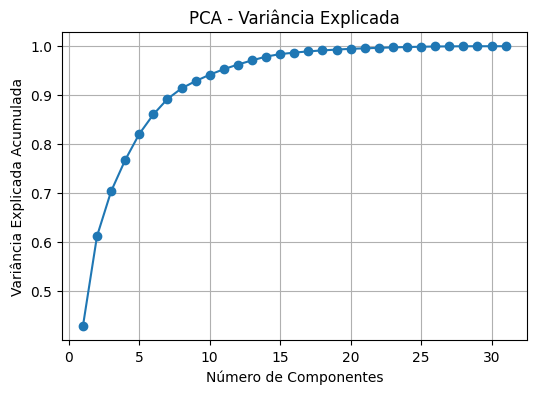

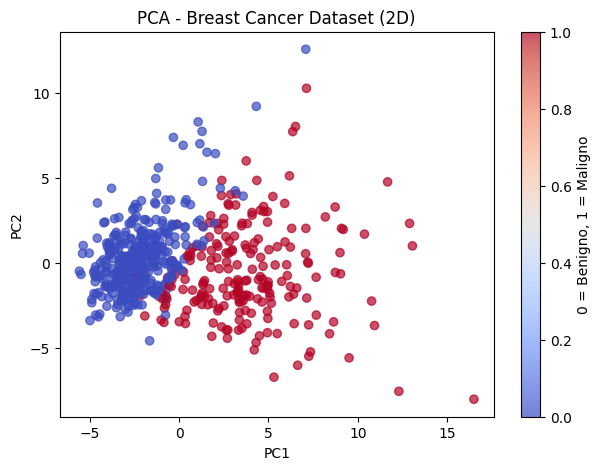

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =========================================
# BREAST CANCER DATASET (Kaggle)
# =========================================

# Carregar dataset Kaggle (ajuste o nome do arquivo conforme seu CSV)
df = pd.read_csv("breast-cancer.csv")

# Se a coluna de diagnóstico for 'diagnosis' ou 'target'
y = df["diagnosis"] if "diagnosis" in df.columns else df["target"]
X = df.drop(["diagnosis"], axis=1) if "diagnosis" in df.columns else df.drop(["target"], axis=1)

# Escalonamento
X_scaled = StandardScaler().fit_transform(X)

# PCA completo
pca = PCA().fit(X_scaled)

# Variância explicada
plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_.cumsum(), marker="o")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("PCA - Variância Explicada")
plt.grid(True)
plt.show()

# PCA 2D
X_pca = PCA(n_components=2).fit_transform(X_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=(y=="M"), cmap="coolwarm", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - Breast Cancer Dataset (2D)")
plt.colorbar(label="0 = Benigno, 1 = Maligno")
plt.show()
